## South America
This notebook contains functions that combine World Database of Protected Areas and Ramsar data for a country or continent to create a full protected areas dataset for the desired region and calculates the total length of rivers on protected lands and total area of protected lands that are affected by proposed dams by country for a desired continent. 

In [1]:
# Imports
import warnings
import os
import sys

import numpy as np
import numpy.ma as ma
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import seaborn as sns

import earthpy as et
import earthpy.plot as ep
import contextily as ctx

In [2]:
# Check path and set working directory.
wd_path = os.path.join(et.io.HOME, 'earth-analytics', 'data')
if os.path.exists(wd_path):
    os.chdir(wd_path)
else:
    print("Path does not exist")

In [3]:
# Download Data stored on figshare
# Free flowing rivers current DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273213")

# Free flowing rivers future DOR
et.data.get_data(url="https://ndownloader.figshare.com/files/23273216")

# World Database of Protected Areas South America
et.data.get_data(url="https://ndownloader.figshare.com/files/23355335")

# Ramsar Sites
et.data.get_data(url="https://ndownloader.figshare.com/files/22507082")

# Country boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/22507058")

# Continent boundaries
et.data.get_data(url="https://ndownloader.figshare.com/files/23392280")

# Continent-country csv
et.data.get_data(url="https://ndownloader.figshare.com/files/23393756")

'C:\\Users\\lherwehe\\earth-analytics\\data\\earthpy-downloads\\continent-country.csv'

In [4]:
# Custon Function
def all_pa_continent(wdpa_polys, ramsar_polys, cont_name):
    """ This function takes WDPA polygons for a continent and global ramsar polygons and returns a multipolygon feature 
    of the World Database of Protected Areas merged with the ramsar areas for that continent.

    Parameters
    ----------
    wdpa_polys: gdf
        The feature with the WDPA polygons for the selected continent.
    ramsar_polys: gdf
        The feature with all global ramsar polygons.
    cont_name: str
        The name of the selected continent.

    Returns
    -------
    wdpa_ramsar: gdf
        A gdf of both the ramsar and WDPA protected areas for the continent.
    """
    # Remove ramsar areas from WDPA dataset
    try:
        wdpa_polys.set_index('DESIG', inplace=True)
        wdpa_polys.drop(
            "Ramsar Site, Wetland of International Importance", inplace=True)
    except:
        print('No ramsar areas in WDPA dataset.')

    # Remove duplicates from WDPA dataset (areas tagged by both state and local authorities)
    try:
        wdpa_polys.set_index('NAME', inplace=True)
        wdpa_polys.drop_duplicates(subset=None,
                                   keep='first', inplace=False)
    except:
        print('No duplicates in the WDPA dataset.')

    # Pull out the ramsar areas for the continent or country and merge with protected areas
    ramsar_polys = ramsar_polys[ramsar_polys["continent"] == cont_name]
    wdpa_ramsar = wdpa_polys.append(ramsar_polys, 'sort=True')

    return wdpa_ramsar

In [5]:
# Open continent & country borders & ISOs
country_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "country-borders",
                                             "99bfd9e7-bb42-4728-87b5-07f8c8ac631c2020328-1-1vef4ev.lu5nk.shp"))

continent_iso = pd.read_csv(os.path.join(wd_path, "earthpy-downloads",
                                         "continent-country.csv"))

continent_borders = gpd.read_file(os.path.join(wd_path, "earthpy-downloads", "continent-poly",
                                               "Continents.shp"))

# Reproject data to World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
country_borders = country_borders.to_crs('epsg:4087')
continent_borders = continent_borders.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [6]:
# Open ramsar areas
ramsar_polys = gpd.read_file(os.path.join(
    "earthpy-downloads", "ramsar-site-data", "ramsar-boundaries",
    "features_publishedPolygon.shp"))

# Rename ramsar columns to match WDPA
try:
    ramsar_polys = ramsar_polys.rename(
        columns={"iso3": "PARENT_ISO", "officialna": "NAME", "area_off": "Shape_Area"})
except:
    print('Ramsar column names already match WDPA dataset.')

# Merge continent names with ramsar data for analyzing by continent
ramsar_polys = pd.merge(ramsar_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Data cleaning - take only necessary ramsar columns
ramsar_polys = ramsar_polys[['NAME', 'PARENT_ISO',
                             'Shape_Area', 'continent', 'geometry']]

# Reproject ramsar data to  World Equidistant Cylindrical, datum WGS84, units meters, EPSG 4087
ramsar_polys = ramsar_polys.to_crs('epsg:4087')

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [7]:
# Open current DOR shapefiles
dor_0to5 = gpd.read_file(os.path.join(wd_path,
                                      "earthpy-downloads", "DOR_Binned", "DOR_0to5.shp"))
dor_5to10 = gpd.read_file(os.path.join(wd_path,
                                       "earthpy-downloads", "DOR_Binned", "DOR_5to10.shp"))
dor_10to15 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_10to15.shp"))
dor_15to20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_15to20.shp"))
dor_over20 = gpd.read_file(os.path.join(wd_path,
                                        "earthpy-downloads", "DOR_Binned", "DOR_over20.shp"))

In [8]:
# Get all current rivers in selected continent
all_rivers_0to5_sam = dor_0to5[dor_0to5['CONTINENT'] == "South America"]
all_rivers_5to10_sam = dor_5to10[dor_5to10['CONTINENT'] == "South America"]
all_rivers_10to15_sam = dor_10to15[dor_10to15['CONTINENT'] == "South America"]
all_rivers_15to20_sam = dor_15to20[dor_15to20['CONTINENT'] == "South America"]
all_rivers_over20_sam = dor_over20[dor_over20['CONTINENT'] == "South America"]

In [9]:
# For loop to (1) calculating difference in DOR between planned and current, (2) pulling only rivers with class > 3,
# (3) projecting rivers, (4) buffer by 1/100 km to become polys for overlay fuction, (5) pull only needed columns

gdf_list = [all_rivers_0to5_sam, all_rivers_5to10_sam, all_rivers_10to15_sam, all_rivers_15to20_sam, all_rivers_over20_sam]
river_list_prj = []

for shp in gdf_list:
    shp['DOR_DIFF'] = shp['DOR_PLA'] - shp['DOR']
    shp = shp[shp.RIV_CLASS > 3] 
    shp = shp.to_crs('epsg:4087')
    shp['geometry'] = shp.buffer(100)
    shp = shp[['LENGTH_KM', 'RIV_ORD', 'RIV_CLASS', 'CONTINENT',
               'ISO_NAME', 'BAS_NAME', 'DOR', 'DOR_PLA', 'DOR_DIFF', 'Shape_Leng', 'geometry']]
    river_list_prj.append(shp)

# Re-assign names based on list index
dor_0to5 = river_list_prj[0]
dor_5to10 = river_list_prj[1]
dor_10to15 = river_list_prj[2]
dor_15to20 = river_list_prj[3]
dor_over20 = river_list_prj[4]

# Concatanate all rivers gdfs for easier analysis later
all_rivers = pd.concat([dor_0to5, dor_5to10, dor_10to15,
                        dor_15to20, dor_over20], axis=0)

# Remove rivers that have DOR_DIFF of 0
all_rivers_lg = all_rivers[all_rivers.DOR_DIFF > 0]

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [10]:
# Analyze South America
# Open WDPA polygons
wdpa_sa_polys = gpd.read_file(os.path.join(wd_path,
                                           "earthpy-downloads", "WDPA_S_America", "WDPA_S_America.shp"))

# Data cleaning - remove polygons with no area & take only the needed columns from WDPA dataset
wdpa_sa_polys = wdpa_sa_polys[wdpa_sa_polys.geometry != None]

# Merge continent names with WDPA data for analyzing by continent
wdpa_sa_polys = pd.merge(wdpa_sa_polys, continent_iso,
                        left_on='PARENT_ISO', right_on='ISO3')

# Take only the columns we need
wdpa_sa_polys = wdpa_sa_polys[[
    'NAME', 'DESIG', 'PARENT_ISO', 'Shape_Area', 'continent', 'geometry']]

# Reporject WDPA data
wdpa_sa_polys = wdpa_sa_polys.to_crs('epsg:4087')

# Get the combined WDPA & ramsar areas for selected continent
wdpa_ramsar_sa = all_pa_continent(wdpa_sa_polys, ramsar_polys, "South America")

# Getting river length affected
# Overlay current rivers on protected areas for selected continent to get ONLY rivers the overlap PAs
river_overlap_sa = gpd.overlay(
    wdpa_ramsar_sa, all_rivers_lg, how='intersection')

# Getting protected areas affected
# Overlay projected rivers on pas for selected continent to get ONLY pas that overlap rivers
pa_overlap_sa = gpd.overlay(
    river_overlap_sa, wdpa_ramsar_sa, how='intersection')

# Get a list of countries in each continent for calculating lengths/areas by country later
sa_countries = continent_iso[continent_iso.continent == 'South America']

# Create empty lists
country_sums = []
area_sums = []
countries = []

# Sum up the total river length affected by country in the continent
for country in sa_countries.ISO3:
    country_sums.append((
        river_overlap_sa.loc[river_overlap_sa['PARENT_ISO'] == country, 'LENGTH_KM'].sum()).round(0))
    area_sums.append((
        pa_overlap_sa.loc[pa_overlap_sa['PARENT_ISO_1'] == country, 'Shape_Area_1'].sum()).round(0))
    countries.append(country)

 # Create a pandas dataframe of lengths and areas affected
sa_output = pd.DataFrame(list(zip(countries, country_sums, area_sums)), columns=[
                           'Country', 'Affected_KM', 'Affected_Area'])

C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\Users\lherwehe\Miniconda3\envs\earth-analytics-python\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [11]:
# Preview Data
sa_output.head()

,Country,Affected_KM,Affected_Area
0,ARG,1003.0,8752591.0
1,BOL,85.0,42.0
2,BVT,0.0,0.0
3,BRA,2921.0,132078167.0
4,CHL,0.0,0.0


In [12]:
sa_affected = sa_output[sa_output.Affected_KM !=0]

sa_affected.head()

,Country,Affected_KM,Affected_Area
0,ARG,1003.0,8752591.0
1,BOL,85.0,42.0
3,BRA,2921.0,132078167.0
5,COL,178.0,1.0
6,ECU,171.0,84329867.0


Text(0.5, -0.1, 'Data Source: fill in text here')

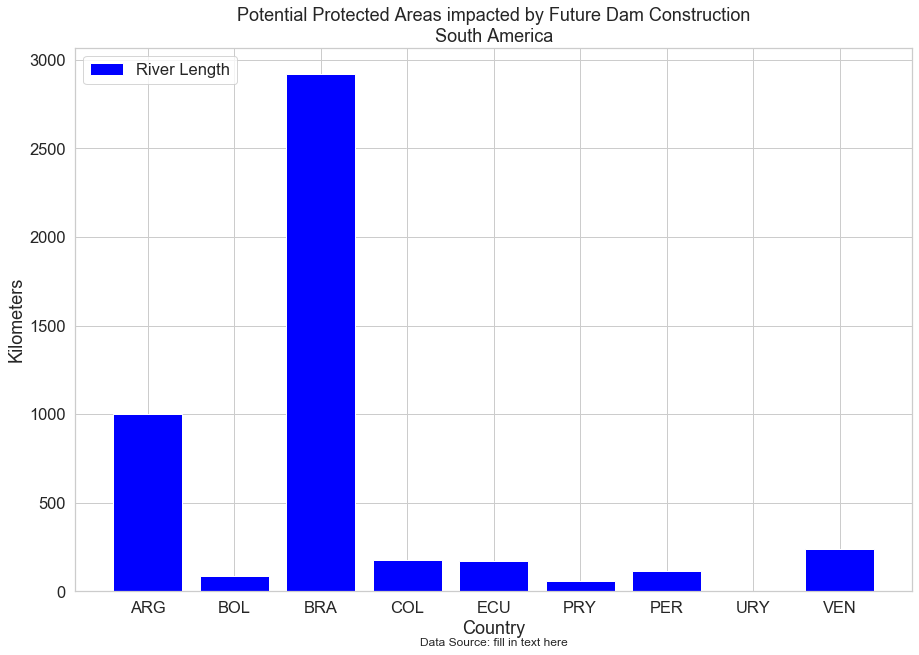

In [26]:
# Create Graph
#use white grid plot background from seaborn
sns.set(font_scale=1.5, style='whitegrid')

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(sa_affected["Country"],
        sa_affected["Affected_KM"], color='blue', label="River Length")
plt.legend(loc="upper left")
ax.set(title="Potential Protected Areas impacted by Future Dam Construction\nSouth America",
       xlabel="Country", ylabel="Kilometers")
ax.text(0.5, -0.1,
        "Data Source: fill in text here",
        size=12,
        ha="center",
        transform=ax.transAxes)

Text(0.5, -0.1, 'Data Source: fill in text here')

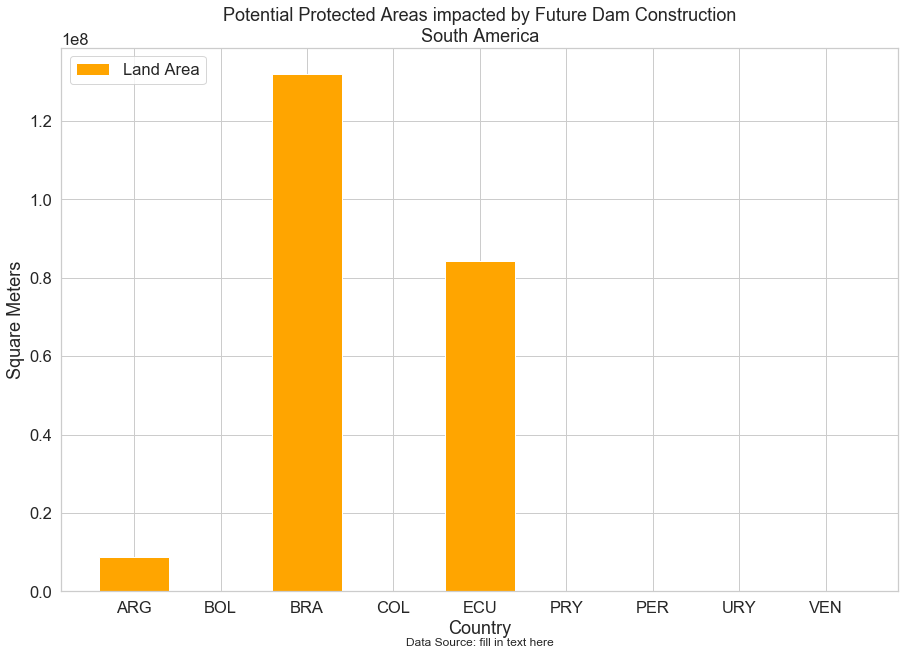

In [28]:
# Create Graph
#use white grid plot background from seaborn
sns.set(font_scale=1.5, style='whitegrid')

fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(sa_affected["Country"],
        sa_affected["Affected_Area"], color='orange', label="Land Area")
plt.legend(loc="upper left")
ax.set(title="Potential Protected Areas impacted by Future Dam Construction\nSouth America",
       xlabel="Country", ylabel="Square Meters")
ax.text(0.5, -0.1,
        "Data Source: fill in text here",
        size=12,
        ha="center",
        transform=ax.transAxes)

In [15]:
# Get continent border for plotting
sam_border = continent_borders[continent_borders['CONTINENT'] == "South America"]

# Buffer rivers for nicer map
dor_0to5 = dor_0to5.buffer(5000)
dor_5to10 = dor_5to10.buffer(5000)
dor_10to15 = dor_10to15.buffer(5000)
dor_15to20 = dor_15to20.buffer(5000)
dor_over20 = dor_over20.buffer(5000)

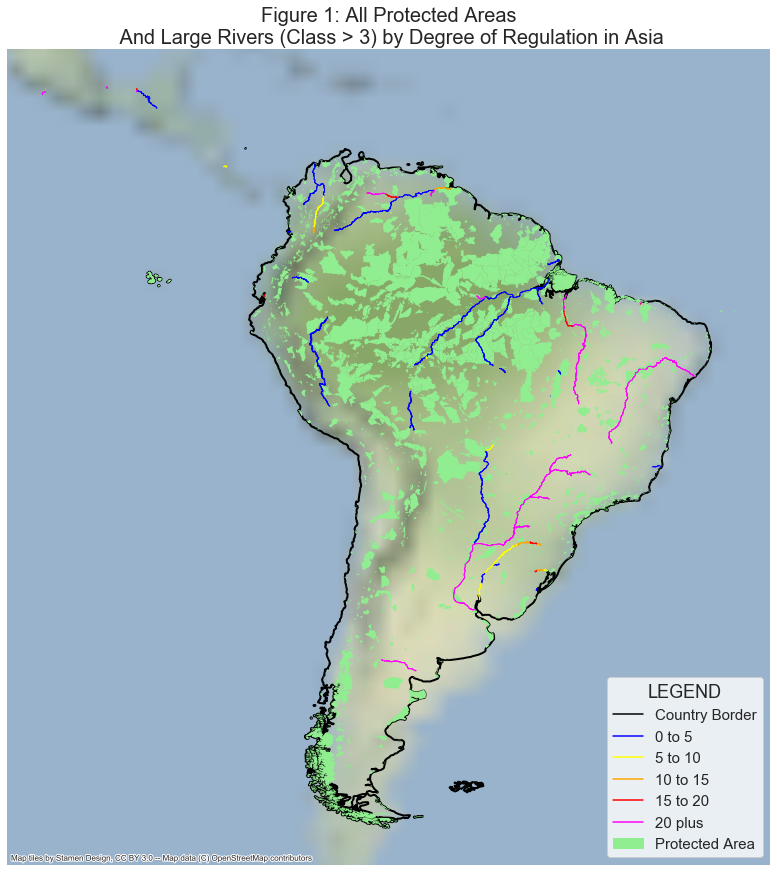

In [20]:
# Plot all rivers and all protected areas for selected continent
# Create legend
black_line = mlines.Line2D([], [], color='black', label='Country Border')
blue_line = mlines.Line2D([], [], color='blue', label='0 to 5')
yellow_line = mlines.Line2D([], [], color='yellow', label='5 to 10')
orange_line = mlines.Line2D([], [], color='orange', label='10 to 15')
red_line = mlines.Line2D([], [], color='red', label='15 to 20')
magenta_line = mlines.Line2D([], [], color='magenta', label='20 plus')
lightgreen_patch = mpatches.Patch(color='lightgreen', label='Protected Area')

fig, ax = plt.subplots(figsize=(15, 15))
sam_border.plot(ax=ax, color="none",  edgecolor="black", linewidth=2)
wdpa_ramsar_sa.plot(ax=ax, color="lightgreen", edgecolor='none')
dor_0to5.plot(ax=ax,
              color='blue', edgecolor='none')
dor_5to10.plot(ax=ax,
               color='yellow', edgecolor='none')
dor_10to15.plot(ax=ax,
                color='orange', edgecolor='none')
dor_15to20.plot(ax=ax,
                color='red', edgecolor='none')
dor_over20.plot(ax=ax,
                color='magenta', edgecolor='none')
ctx.add_basemap(ax, url=ctx.providers.Stamen.Terrain, zoom=0)
ax.set_title(
    'Figure 1: All Protected Areas\n And Large Rivers (Class > 3) by Degree of Regulation in Asia', size=20)
ax.set_axis_off()
ax.legend(handles=[black_line, blue_line, yellow_line, orange_line, red_line, magenta_line, lightgreen_patch],
          fontsize=15,
          frameon=True,
          loc=('lower right'),
          title="LEGEND")